In [39]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tifffile as tiff
import earthpy.plot as ep
from skimage import measure
from skimage import filters
import albumentations as A


In [2]:
image_path = "semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
mask_path = "semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

# Data Visualization


In [3]:
files = os.listdir(mask_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
mask_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
mask_files = sorted(mask_files)

#list o image_paths
mask_list  = []
# Print the list of image files
for mask_file in mask_files:
    mask_list.append(mask_path+"/"+mask_file)
    
    
files_2 = os.listdir(image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [file for file in files_2 if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
image_files = sorted(image_files)

#list o image_paths
original_image_list  = []
# Print the list of image files
for image_file in image_files:
    original_image_list.append(image_path+"/"+image_file)

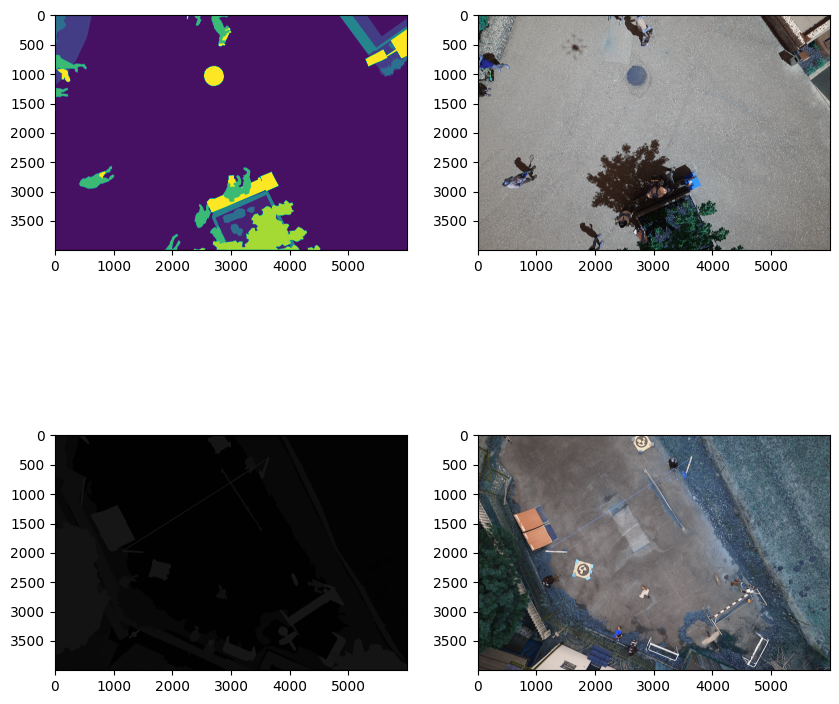

In [5]:
# Exmple of our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# Here Imgae library change just the way of visualisation from grayscale to another space color
ax[0][0].imshow(Image.open(mask_list[0]))
ax[0][1].imshow(cv2.imread(original_image_list[0]))
ax[1][0].imshow(cv2.imread(mask_list[1]))
# CV2 display the mask in original form is the grayscale
ax[1][1].imshow(cv2.imread(original_image_list[1]))

### The following code for displaying the diffirence grayscales values for specifiying the class of trees

### We can see after that 19 is the grayscale of trees and 20 the grayscale of bald trees

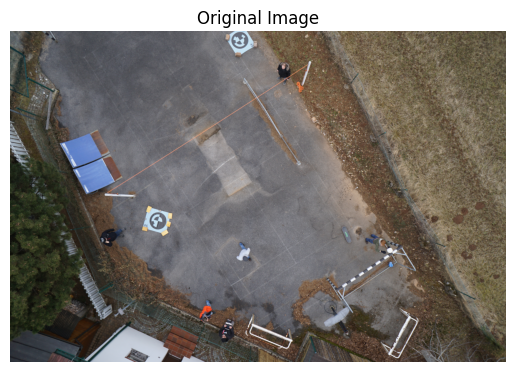

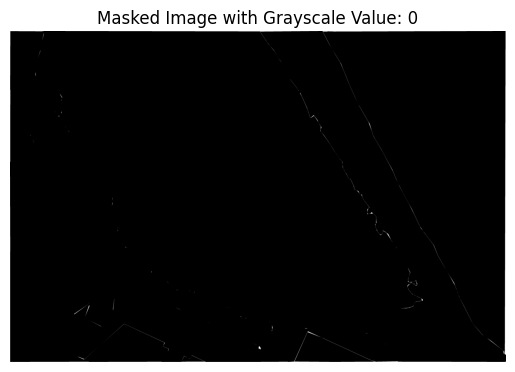

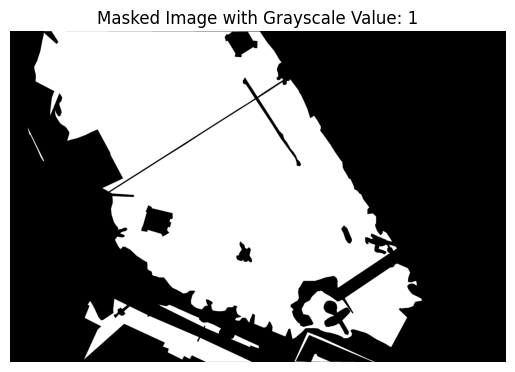

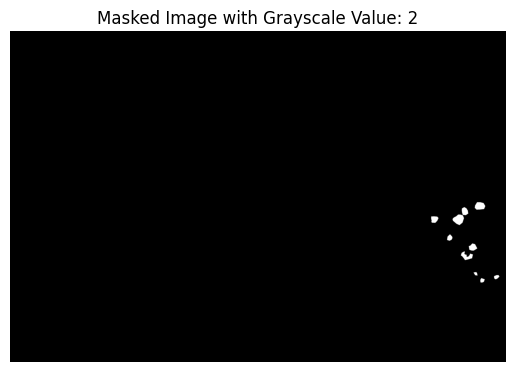

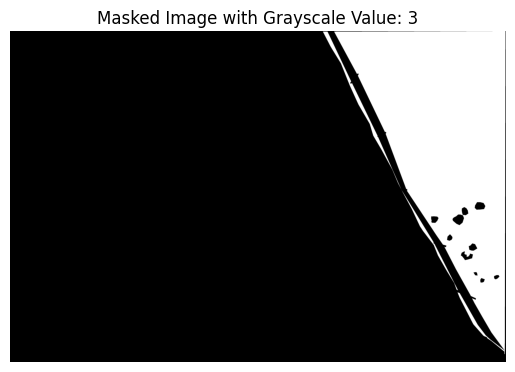

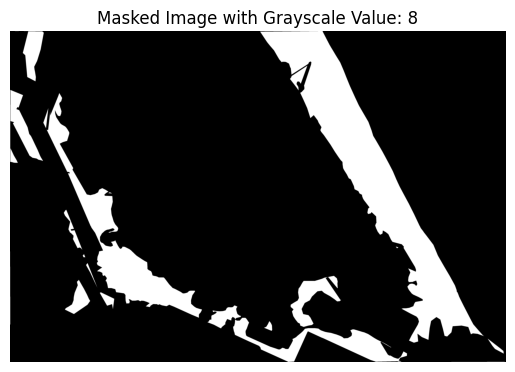

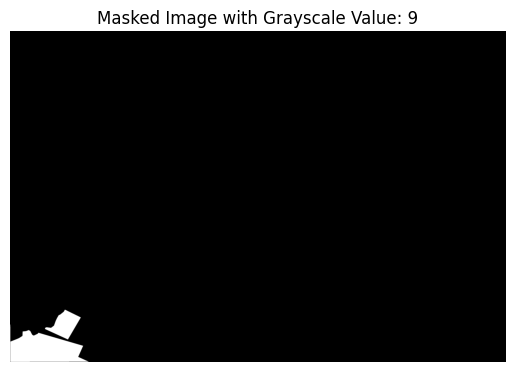

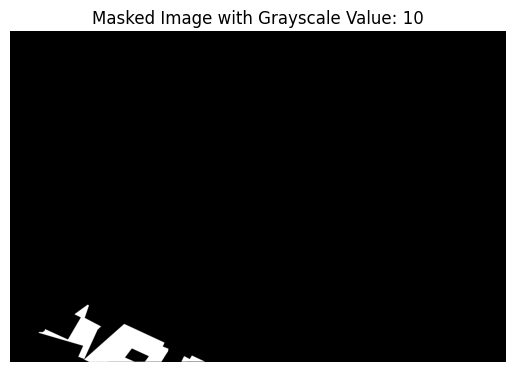

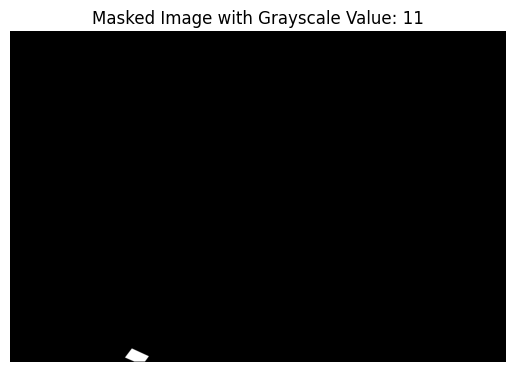

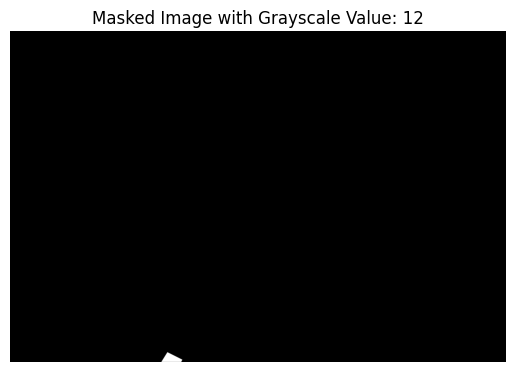

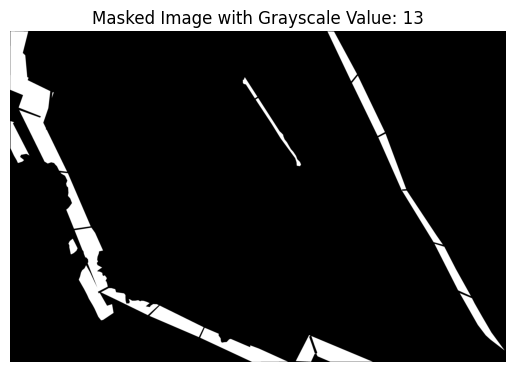

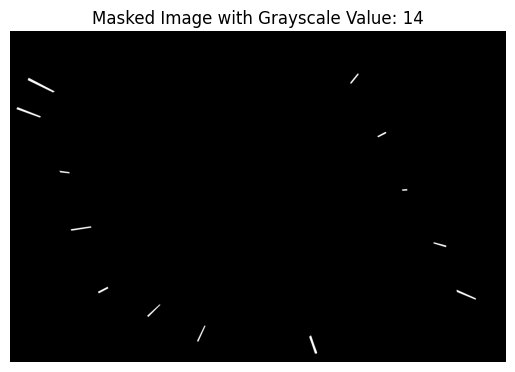

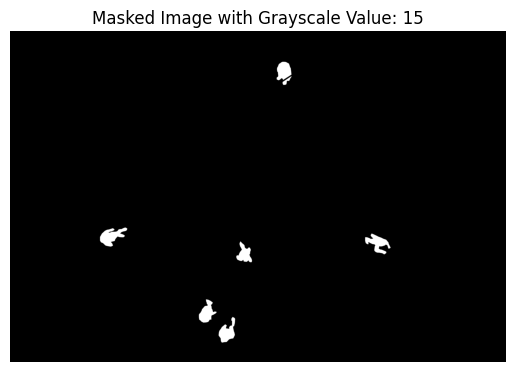

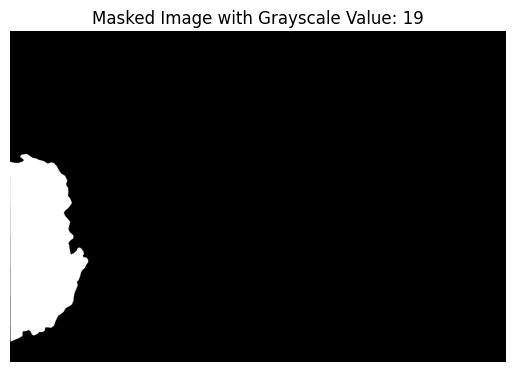

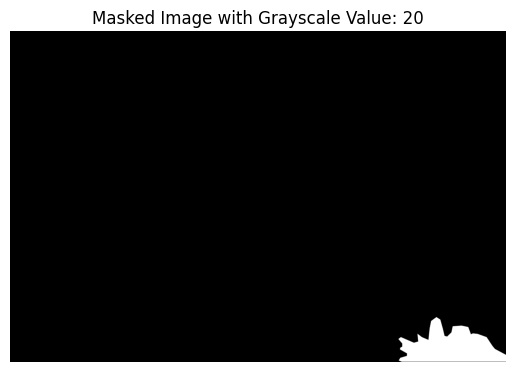

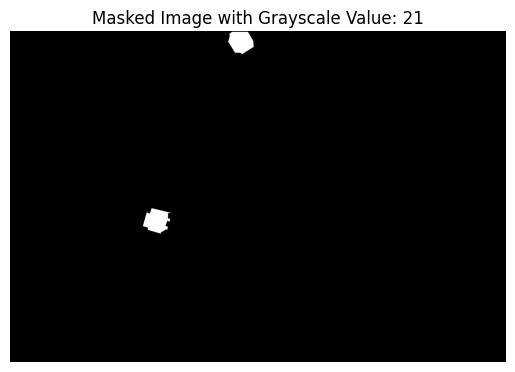

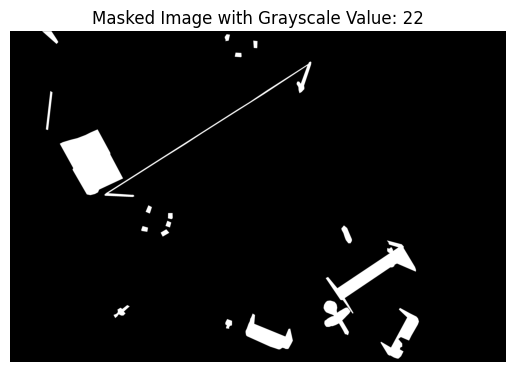

In [7]:
image_idx = 1
# Define the path to your image
mask_path = mask_list[image_idx]
original_image = original_image_list[image_idx]
# Load the image and convert to grayscale
mask_image = Image.open(mask_path).convert("L")
image_array = np.array(mask_image)

image =  Image.open(original_image)

# Get the unique grayscale values in the image
unique_values = np.unique(image_array)

# Plot the original image before the loop
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


# Loop through each unique grayscale value and create a masked image
for value in unique_values:
    # Create a mask that keeps only the current grayscale value
    mask = (image_array == value).astype(np.uint8) * 255

    # Convert the mask to an image
    masked_image = Image.fromarray(mask)

    # Display the masked image
    plt.imshow(mask, cmap='gray')
    plt.title(f"Masked Image with Grayscale Value: {value}")
    plt.axis('off')
    plt.show()

### Save only the grayscale of trees after we define it is 19 and 20 this values can be chaged it if we working with another datasets

In [14]:
image_list = mask_list
# Create a directory to save the processed images
output_dir = "semantic-drone-dataset/dataset/semantic_drone_dataset/trees_masks_new"
os.makedirs(output_dir, exist_ok=True)

# Define the grayscale values to check and their new values
value_mapping = {19: 1,20 :1}

# Process each image in the list
for image_path in image_list:
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)

    # Initialize a new array with zeros
    new_image_array = np.zeros_like(image_array, dtype=np.uint8)

    # Map the specified grayscale values to new values
    for old_value, new_value in value_mapping.items():
        new_image_array[image_array == old_value] = new_value

    # Check if any of the specified grayscale values are present in the image
    if np.any(np.isin(image_array, list(value_mapping.keys()))):
        # Convert the new array to an image
        new_image = Image.fromarray(new_image_array)
        # Save the new image
        base_name = os.path.basename(image_path)
        name, ext = os.path.splitext(base_name)
        output_image_path = os.path.join(output_dir, f"{name}{ext}")
        new_image.save(output_image_path)

print(f"Processed images saved in {output_dir}")

Processed images saved in semantic-drone-dataset/dataset/semantic_drone_dataset/trees_masks_new


### Check if the grayscale of saved images between [0 and n_classes - 1] we writing n_classes because you can define multiple classes just with few changes in the code

In [22]:
img_test = output_dir+"/"+"001"+".png"
mask = np.array(Image.open(img_test))
np.unique(mask)
# The output 0 or 1 or both of our grayscale 

array([0, 1], dtype=uint8)

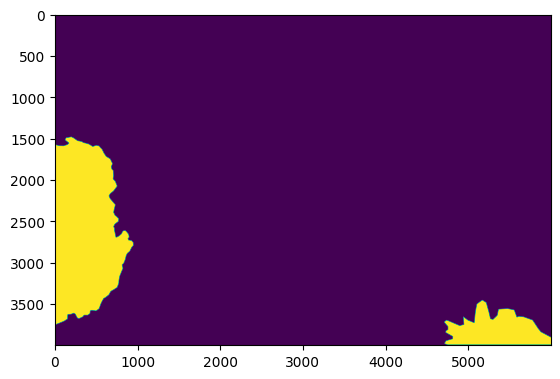

In [26]:
plt.imshow(Image.open(img_test))
# We using Image to opening the image with a diffirence space color

### The augmentations that we do before training the data

In [40]:
train_transform = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise(),
], additional_targets={'mask': 'mask'})

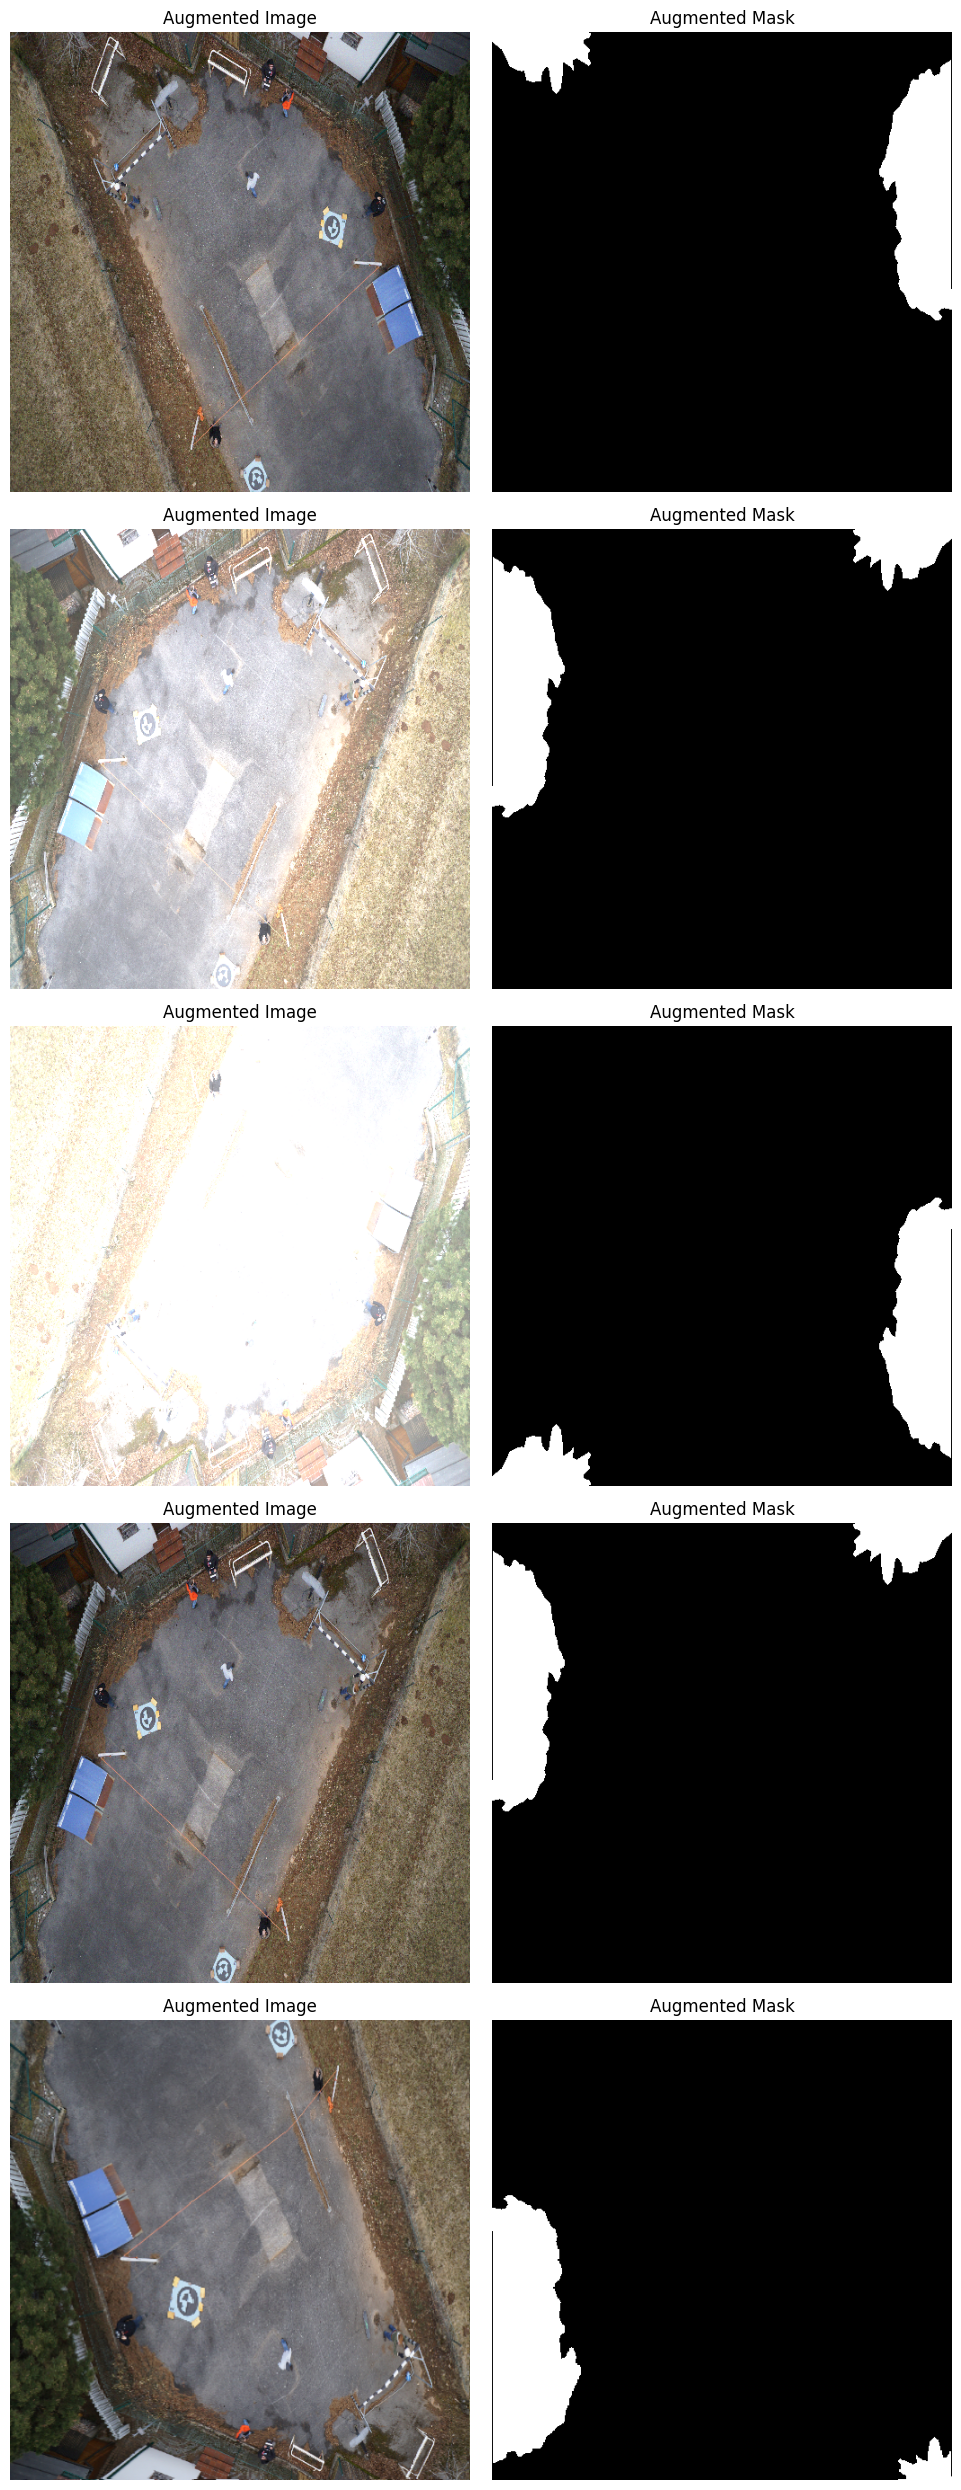

In [52]:
def visualize_augmentations(image, mask, transform, num_examples=5):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 5 * num_examples))

    for i in range(num_examples):
        augmented = transform(image=image, mask=mask)
        aug_image = augmented['image']
        aug_mask = augmented['mask']

        axes[i, 0].imshow(aug_image)
        axes[i, 0].set_title("Augmented Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(aug_mask, cmap='gray')
        axes[i, 1].set_title("Augmented Mask")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

original_images_path = "semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
mask_path_original = "semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

image = original_images_path + "/001.jpg"
mask = output_dir + "/001.png"
# Load image and mask
image = np.array(Image.open(image).convert("RGB"))
mask = np.array(Image.open(mask))  # Assuming mask is already in the correct format

visualize_augmentations(image, mask, train_transform)

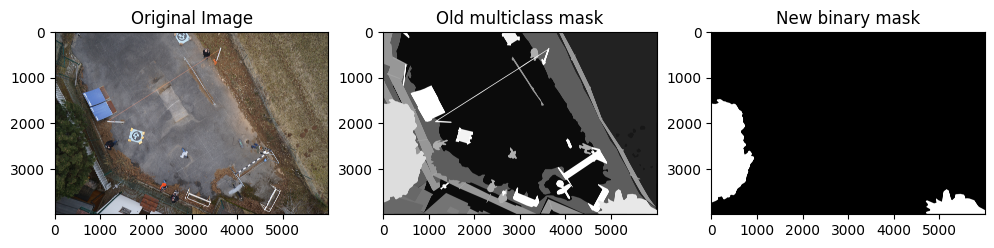

In [53]:
# Plot the input image and the predicted mask
idximg = "001"
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(original_images_path+"/"+idximg+".jpg"))
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(Image.open(mask_path_original+"/"+idximg+".png"),cmap='gray')
plt.title("Old multiclass mask")
plt.subplot(1, 3, 3)
plt.imshow(Image.open(output_dir+"/"+idximg+".png"),cmap='gray')
plt.title("New binary mask")
plt.show()